<CENTER><img src="../../images/ATLASOD.gif" style="width:50%"></CENTER>

# Find the Z boson yourself!
This notebook uses ATLAS Open Data http://opendata.atlas.cern to show you the steps to find the Z boson.

The whole notebook takes less than an hour to follow through.

Notebooks are web applications that allow you to create and share documents that can contain:
1. live code
2. visualisations
3. narrative text

Notebooks are a perfect platform to develop in Python, since you'll need exactly those 3 things: code, visualisations and narrative text!

By the end of this notebook you will be able to:
1. find the Z boson yourself
2. know some things you can change to improve your measurement

<CENTER><img src="images/feynman_diagrams/Zee_feynman.png" style="width:40%"></CENTER>

<a id='contents'></a>

Contents: 

[Running a Jupyter notebook](#running) <br />
[To setup everytime](#setupeverytime) <br />
[Where's my data](#fraction) <br />
[Calculate that invariant mass!](#good_leptons) <br />
[Can we process the data yet?!](#load_data) <br />
[Plot Data](#plot_data) <br />
[Your tasks](#tasks) <br />
[Going further](#going_further) <br />

<a id='running'></a>

## Running a Jupyter notebook

To run the whole Jupyter notebook, in the top menu click Cell -> Run All.

To propagate a change you've made to a piece of code, click Cell -> Run All Below.

You can also run a single code cell, by using the keyboard shortcut Shift+Enter.

[Back to contents](#contents)

<a id='setupeverytime'></a>

## To setup everytime
We're going to be using a number of tools to help us:
* urllib: let us download files
* uproot: lets us read .root files typically used in particle physics into data formats used in Python
* pandas: lets us store data as dataframes, a format widely used in Python
* numpy: provides numerical calculations such as histogramming
* matplotlib: common tool for making plots, figures, images, visualisations

In [1]:
import urllib.request # for downloading files
import pandas as pd # to store data as dataframes
import numpy as np # for numerical calculations such as histogramming
import uproot3 # to read .root files as dataframes
import matplotlib.pyplot as plt # for plotting

<a id='fraction'></a>

## Where's my data?

In [2]:
filename = 'data_D.exactly2lep.root'
url = 'https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/exactly2lep/Data/'+filename
urllib.request.urlretrieve(url, filename)

('data_A.exactly2lep.root', <http.client.HTTPMessage at 0x7f3eed67b130>)

[Back to contents](#contents)

<a id='good_leptons'></a>

## Calculate that invariant mass!

Fill in the missing lines to calculate invariant mass.

1. If the energy of the 2 leptons are *lep_E[0]* and *lep_E[1]*, write the sum of energy, *sumE*
2. Write the sum of x-momentum, *sumpx*
3. Do the same for y and z momenta (*sumpy* and *sumpz*)
4. Now you have the x,y,z components sumpx,sumpy,sumpz. The vector **sump** = (sumpx,sumpy,sumpz). Write the magnitude of total momentum, *sump*.

The invariant mass, *M*, of a parent particle decaying to two daughter particles is related to properties of the daughter particles by the formula:

$$M^2=E^2-p^2,$$

where *E* is the total energy of the daughter particles, and *p* is the magnitude of the vector sum of the momenta of the daughter particles. This is written in natural units with *c*=1.

5. Write *Mll* using this formula for invariant mass

In [4]:
# calculate dilepton invariant mass
def calc_mll(lep_pt,lep_eta,lep_phi,lep_E): # lepton pt,eta,phi,energy
    
    # 0th lepton is [0], next lepton is [1] etc
    # get the energy of 0th lepton by lep_E[0]

    # sumE = sum of energy
    sumE = lep_E[0]+lep_E[1]
    
    px_0 = lep_pt[0]*np.cos(lep_phi[0]) # x-momentum of 0th lepton
    px_1 = lep_pt[1]*np.cos(lep_phi[1]) # x-momentum of 1st lepton
    py_0 = lep_pt[0]*np.sin(lep_phi[0]) # y-momentum of 0th lepton
    py_1 = lep_pt[1]*np.sin(lep_phi[1]) # y-momentum of 1st lepton
    pz_0 = lep_pt[0]*np.sinh(lep_eta[0]) # z-momentum of 0th lepton
    pz_1 = lep_pt[1]*np.sinh(lep_eta[1]) # z-momentum of 1st lepton
    
    # sumpx = sum of x-momenta
    sumpx = px_0+px_1
    
    # sumpy = sum of y-momenta
    sumpy = py_0+py_1
    
    # sumpz = sum of z-momenta
    sumpz = pz_0+pz_1
    
    # sump = magnitude of total momentum vector. Remember it's a vector!
    sump = np.sqrt(sumpx*sumpx+sumpy*sumpy+sumpz*sumpz)
    
    # Mll = invariant mass from M^2 = E^2 - p^2
    Mll = np.sqrt(sumE*sumE-sump*sump)
    
    return Mll/1000 # divide by 1000 to go from MeV to GeV
    

<a id='load_data'></a>

## Can we process the data yet?!

In [7]:
data_all = pd.DataFrame() # define empty pandas DataFrame to hold all data for this sample
tree = uproot3.open(filename)["mini"] # open the tree called mini
numevents = uproot3.numentries(filename, "mini") # number of events

# Create a list to store individual DataFrames
dfs = []

for data in tree.iterate(['lep_pt','lep_eta','lep_phi','lep_E'], 
                         outputtype=pd.DataFrame, # choose output type as pandas DataFrame
                         entrystop=numevents*0.01): # stop after fraction of events we want to process

    # calculation of 2-lepton invariant mass                                                                                                                                      
    data['mll'] = np.vectorize(calc_mll)(data.lep_pt, data.lep_eta, data.lep_phi, data.lep_E)
    
    #print(data['mll'])
    #data_all = data_all.append(data) # append dataframe from this batch to the dataframe for the whole sample
    # Append the DataFrame to the list
    dfs.append(data)

# Concatenate all DataFrames in the list
data_all = pd.concat(dfs, ignore_index=True)

[Back to contents](#contents)

<a id='plot_data'></a>

## Function to plot Data

Text(0, 0.5, 'Events')

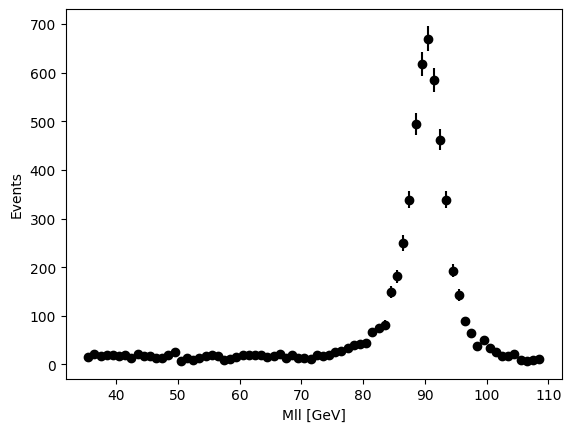

In [8]:
bin_edges = np.arange(start=35, # The interval includes this value
                      stop=110, # The interval doesn't include this value
                      step=1 ) # Spacing between values
bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2 # central values of each bin

# histogram the data
data_x,_ = np.histogram(data_all['mll'], bins=bin_edges ) 

# statistical error on the data
data_x_errors = np.sqrt(data_x)

# plot the data points
plt.errorbar(x=bin_centres, 
                   y=data_x, 
                   yerr=data_x_errors,
                   fmt='ko' ) # 'k' means black and 'o' is for circles

# x-axis label
plt.xlabel('Mll [GeV]')

# y-axis label
plt.ylabel('Events')

# make the y-axis log scale
#plt.yscale('log')

Compare this with "Total Cross Section" as a function of "Center of Mass Energy".

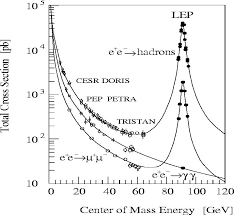

<a id='tasks'></a>

## Your tasks

1. Write the invariant mass formula, $M^2=E^2-p^2$, with *c* included.
2. Calculate the invariant mass for the first event, in GeV. 
    * lep_px[0] = 32387 MeV, 
    * lep_px[1] = -18772 MeV, 
    * lep_py[0] = 7047 MeV, 
    * lep_py[1] = -9563 MeV, 
    * lep_pz[0] = 144152 MeV, 
    * lep_pz[1] = -2942 MeV, 
    * lep_E[0] = 147913 MeV, 
    * lep_E[1] = 21272 MeV 
    * (can you check these values yourself?)
    * (can you check your calculated value?)
3. If lep[0] in the first event is an electron, what's its Lorentz factor, $\gamma$? Use an electron mass of 0.5 MeV in the formula $E = \gamma m$
4. Calculate lep_p[0], the magnitude of the total momentum of lep[0].
5. Using lep_p[0], calculate the speed of this electron. Use the formula $p = \gamma mv/c$
6. Write the possible Z decays into charged leptons. Give an argument as to whether or not each decay happens at the same rate.
7. Besides charged leptons, what are the other possible decays of the Z?

[Back to contents](#contents)

Finding the Z boson in ATLAS data is a case of calculating invariant mass and plotting a range up to about 100 GeV. The Z boson then shows up in your graph!

Hopefully you've enjoyed finding the Z boson yourself!

<a id='going_further'></a>

## Going further

If you want to go further, there are a number of things you could try: 
* **Estimate the mass of the Z boson** from your graph.
* **Estimate the width of the Z boson** from your graph.
* **Increase the fraction** of events processed. In the line `entrystop=numevents*` in '[Can we process the data yet?!](#load_data)', increase the number from 0.001. 
* **Use larger data files**. `data_A` used so far corresponds to an integrated luminosity of 0.5 fb$^{-1}$. Other files include: `data_B` 1.9 fb$^{-1}$, `data_C` 2.9 fb$^{-1}$, `data_D` 4.7 fb$^{-1}$. Try one of these larger files.
* **Use all data files together**. `data_A` + `B` + `C` + `D` corresponds to about 1/14th of the data collected by ATLAS at a centre-of-mass energy of 13 TeV - the highest energy particle collisions achieved on earth.
* **Write the name of the type of peak shown in your graph**.
* **Make a fit to your graph**.
* **Extract the Z boson mass from your fit**.
* **Extract the Z boson width from your fit**.

With each change, keep an eye on your graph.

[Back to contents](#contents)